# Modis
The following notebook goes through the working process with MODIS data used in the project Detectiong of forest fires using a Convolutional Neural Network with Synthetic aperature radar. Many methods exists for e.g. downloading and preprocessing. The process here is useful for getting active fire data, and using it as labels for e.g. a Neural Network.

##### The notebook contains:
* Background knowlagde on MODIS, its data, and how to acces it. For more information, see the Report.
* Loading MODIS data
* Plotting MODIS data




# Background

### Acces data
MODIS's active fire product can be used to fetch data on where fires have been. If the user doesnt know exactly where the fires have been, it is a hassle to obtain historical data. Therefore, for locations on fire, see e.g. https://effis.jrc.ec.europa.eu/static/effis_current_situation/public/index.html. 

There are many locations where the MODIS data can be accesed, depending on the specific goal,  e.g. here: https://modis.gsfc.nasa.gov/data/ - From this site you will be sent to another page to download your wanted dataset. (NASA has oursources the processing to different players, hence different datasets are on different websites)

MODIS has an active fire dataset that:
  - detects fires and other thermal anomalis.
  - has 1 km resolution
  - Swath data or tiled in a sinosoudal projection.
  
This can be accesed from 

https://search.earthdata.nasa.gov/search

https://modis.gsfc.nasa.gov/data/dataprod/mod14.php

https://search.earthdata.nasa.gov/search/granules?p=C194001243-LPDAAC_ECS&q=MOD14A2&tl=1568635214!4

For historical data, use https://firms.modaps.eosdis.nasa.gov/download/create.php


#### File format

Different kinds og dataformat exists, e.g. json, shp and csv or as in this case, .shp.
file format will be .shp. The name of the .shp file will cary information on the downlaoded product

#### working with the data in short
To load the date one must handle this geospatial .shp data. One library for this is gdal. (Geospatial abstraction library).  Use the conda forge installation since pip is bad.. $conda install gdal


Working with the data can be learned using these links:

https://lpdaac.usgs.gov/resources/e-learning/getting-started-modis-version-6-thermal-anomalies-and-fire-data-part-1-all-about-accessing-data/

https://lpdaac.usgs.gov/resources/e-learning/getting-started-modis-version-6-thermal-anomalies-and-fire-data-part-2-using-data/

https://lpdaac.usgs.gov/resources/e-learning/getting-started-modis-version-6-thermal-anomalies-and-fire-data-part-3-interpreting-quality-information/



# Functions....

In [1]:
import os
from glob import glob
import math
from matplotlib import pyplot as plt
import math
from rasterio import plot as rioplot
import geopandas as gpd
import gdal
import ogr
import osr
import gdalnumeric
import gdalconst
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from rasterio.plot import show
from rasterio import plot as rioplot
# Prepare enviroment.
import gdal
import ogr
import osr
import gdalnumeric
import gdalconst
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
import numpy as np
from rasterio.plot import show
from rasterio import plot as rioplot
import sys
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\code')
import my_s1 as s1
import my_modis as modis
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt



def modistoshape(path='',verbose=1,file_type='shp'):
    """
    Takes a path, finding all modis data in the dir and sub dir, 
    and load those.
    
    inputs
        path[str]: string of path. 
        verbose[int]: information. If verbose>0 info will be printed.
        file_type[str]: extention of files. Default is .shp files.
        
    output:
        file_paths[str]: table of path strings.
        
    Example:
        temp = modistoshape('C:\\Users\\krist\syntese\data',verbose=0)
        
    Author: 
        Kristian Aalling Soerensen
        22. May 2020
        kristian.sorensen@hotmail.com
    """
    allowed_types = ['shp']
    assert (file_type in allowed_types),('\nERROR: '+file_type+': Illegal file type.')
    
    #getting current dir.
    cwd = os.getcwd()
    file_paths = []
    
    if path is '':
        start_dir = os.getcwd()
    
    if path is not '':
        start_dir = path
        if verbose>1:
            print('\nChangin dir to: '+start_dir)

    
    
    extention   = "*."+file_type
    for dir,_,_ in os.walk(start_dir):
        file_paths.extend(glob(os.path.join(dir,extention))) 
    
    assert len(file_paths)>0, ('\nERROR: No files of type:'+file_type+' in dir.')
    
    if verbose>0:
        print('\nthere are:',len(file_paths),' .',file_type,' files in folder')
    if verbose>1:
        print(file_paths)
    
    os.chdir(cwd)
    if verbose>1:
        print('\n Changin dir to: '+cwd)
        
    return file_paths

def plotfire_shp(df_fire,title='fire'):
    """
        this fucntion plots the fires..
    """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #sweden = gpd.read_file('modis/Sweden.shp')
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    Sweden = world.query('name == "Sweden"')
    Norway = world.query('name == "Norway"')
    Denmark = world.query('name == "Denmark"')
    
    ax = df_fire.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    Sweden.plot(ax=ax, color='white', edgecolor='goldenrod',cmap='YlGn',alpha=1)
    Norway.plot(ax=ax, color='white', edgecolor='blue',cmap='Blues',alpha=1)
    Denmark.plot(ax=ax, color='white', edgecolor='red',cmap='Reds',alpha=1)
    df_fire.plot(column=df_fire.columns[2],
               ax=ax,
               legend=True,
               legend_kwds={'label': "Brightness",'orientation': "horizontal"},
                 cmap = 'YlOrRd')
    

    
    #plt.title(title)
    #df.columns[2]
    plt.xlim(5, 25)
    plt.ylim(55,70)
    plt.ylabel('latitude', fontsize=20)
    plt.xlabel('longitude', fontsize=20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    
    plt.savefig(title+'.png', bbox_inches='tight')
    
    plt.show()
    
    
    return None

def get_fires(modis_data='shapefile',folder_name='geojson',verbose=0):
    """
        This function takes the fires in a shapefile, and turn it into geojson footprint.
        This footprint can then be used to download other day.
        
        Input:
            modis_data: a shafile with the fires, as loaded using modistoshape()
            folder_name: A string with the path for the files,
            verbose: how much info you wanna see.
        output:
            None. geojson files will be saved in folder
        example:
            get_fires(modis_data=shps[2],folder_name='geojson',verbose=0)
            
        Authro:
            Kristian Soerensen
            June 2020
            kristian.sorensen@hotmail.com
    """
    #all the fires
    data_FIRMS = gpd.read_file(modis_data)
    #only find fires with high confidence, high brightness and high confidence
    fires_used = data_FIRMS[(data_FIRMS[data_FIRMS.columns[2]]>260)  & (data_FIRMS[data_FIRMS.columns[11]]>250) & (data_FIRMS[data_FIRMS.columns[12]]>100) & (data_FIRMS[data_FIRMS.columns[9]]>90)]
    #creating a folder for .geojson files it it doesnt exitst.
    if not os.path.exists('geojson'):
        os.makedirs('geojson')
        
    #getting current dir, and changing dir to geojson
    cwd = os.getcwd()
    if verbose>0:
        print('------------------------------')
        print('(get_fires): Changing directory to '+str(cwd)+"/geojson")
        print('------------------------------')
        
    os.chdir(cwd+"/geojson")
    #now, these fires shoulw be made into geojson so it can be used to find sentinel 1 images. 
    temp_var = 0
    for i in range(len(fires_used)):
        # used to count..
        
        #making the name of the file
        name=str(fires_used['INSTRUMENT'].iloc[i])+'_'+str(fires_used['ACQ_DATE'].iloc[i])+'_'+str(fires_used['LATITUDE'].iloc[i])+'_'+str(fires_used['LONGITUDE'].iloc[i])+'.geojson'
        #only create the file if it doesnt exist...
        if os.path.exists(str(cwd)+"/geojson/"+name)==True:
            if verbose>0:
                print(str(i+1)+' (get_fires): file '+name+" already exists")
            
        if os.path.exists(str(cwd)+"/geojson"+name)==False: 
            temp_var = temp_var+1
            #getting coordiantes for point, used to make footprint
            latitude = fires_used['LATITUDE'].iloc[i]
            longitude = fires_used['LONGITUDE'].iloc[i]
            #getting the point for geojson
            point = Point((longitude,latitude))
            #its features(actually not needed for the foodprint)
            features = []
            features.append(Feature(geometry=point, properties={"BRIGHTNESS": str(fires_used['BRIGHTNESS'].iloc[i])}))
            features.append(Feature(geometry=point, properties={"INSTRUMENT": str(fires_used['INSTRUMENT'].iloc[i])}))
            features.append(Feature(geometry=point, properties={"ACQ_DATE": str(fires_used['ACQ_DATE'].iloc[i])}))
            features.append(Feature(geometry=point, properties={"FRP": str(fires_used['FRP'].iloc[i])}))
            features.append(Feature(geometry=point, properties={"CONFIDENCE": str(fires_used['CONFIDENCE'].iloc[i])}))
            features.append(Feature(geometry=point, properties={"BRIGHT_T31": str(fires_used['BRIGHT_T31'].iloc[i])}))
            features.append(Feature(geometry=point, properties={"ACQ_DATE": str(fires_used['ACQ_DATE'].iloc[i])}))

            feature_collection = FeatureCollection(features)
            
            
            #creating file
            with open(name, 'w') as f:
                dump(feature_collection, f)
    if verbose>0:
        if temp_var>0:
            print('(get_fires): '+str(temp_var+1)+' .geojson files are made')
        print('------------------------------')
        print('(get_fires): Changing directory back to '+str(cwd))
        print('------------------------------')            
    #going back to original dir
    os.chdir(cwd)
            
    return None   

# Walkthorough

The data needed must be saved in a designated label folder. In this current project, the data folder contains sentinel-2, sentinel-1, sentinel-3 and MODIS data.
The MODIS data is in .shp format. The paths are found using the modistoshape() funciton.

In [3]:
Path = 'C:\\Users\\krist\\Documents\\Syntese\\data\\modis'

In [4]:
shps = modis.modistoshape(path=Path,verbose=1,file_type='shp')


there are: 4  . shp  files in folder


The shp file can now be read using geopandas library

In [5]:
data_FIRMS = gpd.read_file(shps[3])
data_FIRMS.tail()
print(data_FIRMS.crs)
modis.plotfire_shp(data_FIRMS,'Fires in Sweden, May thorugh August')

epsg:4326


NameError: name 'mod' is not defined


Looks good.

### Displaying all the fires

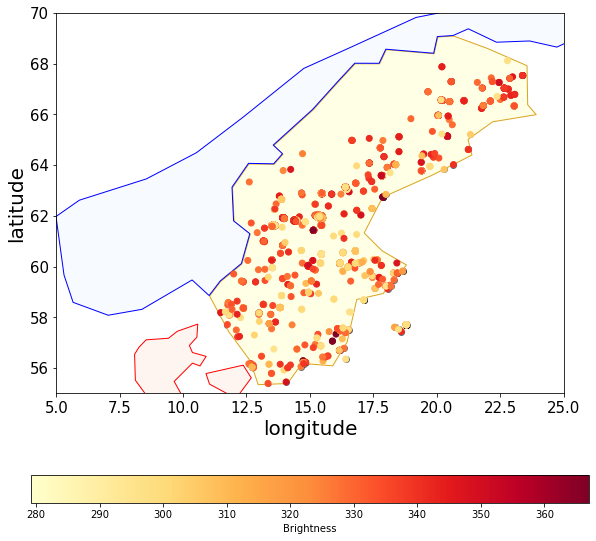

In [8]:
mod.plotfire_shp(data_FIRMS,'All fires')

Again, look at the attributes. There are different types. These sets can be made. 

In [9]:
fire_0 = data_FIRMS[(data_FIRMS.TYPE==0)]
fire_1 = data_FIRMS[(data_FIRMS.TYPE==1)]
fire_2 = data_FIRMS[(data_FIRMS.TYPE==2)]
fire_3 = data_FIRMS[(data_FIRMS.TYPE==3)]

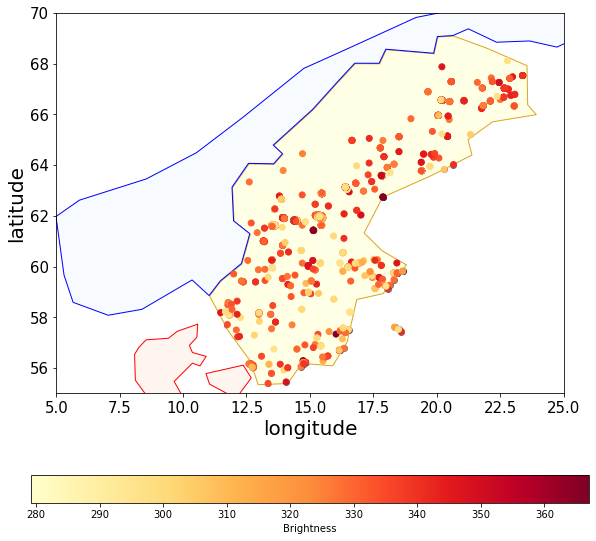

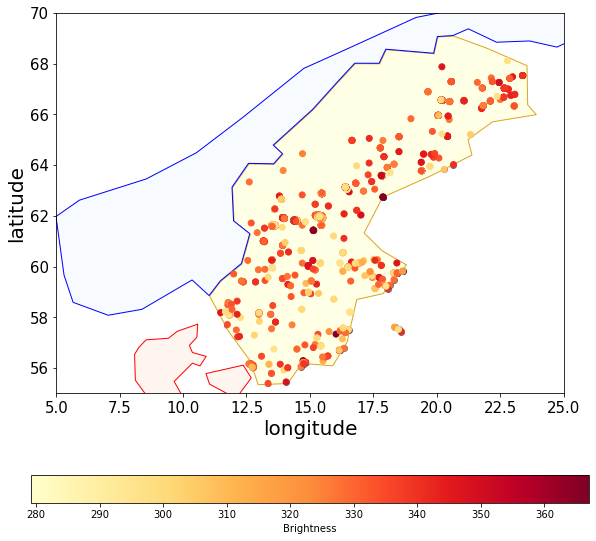

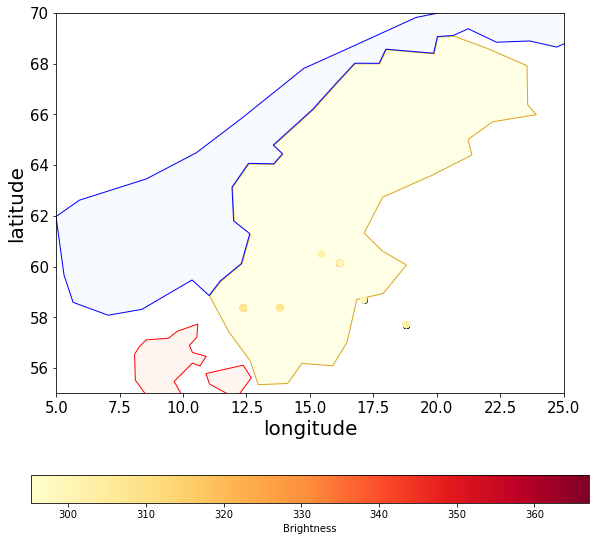

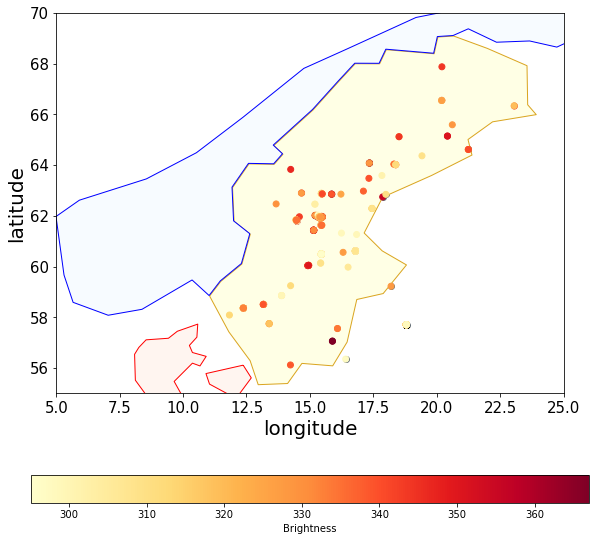

In [12]:
mod.plotfire_shp(fire_0,'fire type 0')
mod.plotfire_shp(fire_0,'fire type 1')
mod.plotfire_shp(fire_2,'fire type 2')
mod.plotfire_shp(fire_3,'fire type 3')

## Thresholding fires to find the biggest ones

In [25]:
biggest_firest = data_FIRMS[(data_FIRMS.BRIGHT_TI4>330) & (data_FIRMS.FRP>150) & (data_FIRMS.LATITUDE>61.5)]

Saving the biggest fires as a json so it can be seen and plotted in e.g. QGISwith open('fires_modis.geojson', 'w') as f:
    f.write(biggest_firest.to_json())
with open('all_fires_modis.geojson', 'w') as f:
    f.write(data_FIRMS.to_json())   
    
    

In [26]:
with open('fires_modis.geojson', 'w') as f:
    f.write(biggest_firest.to_json())
with open('all_fires_modis.geojson', 'w') as f:
    f.write(data_FIRMS.to_json())   

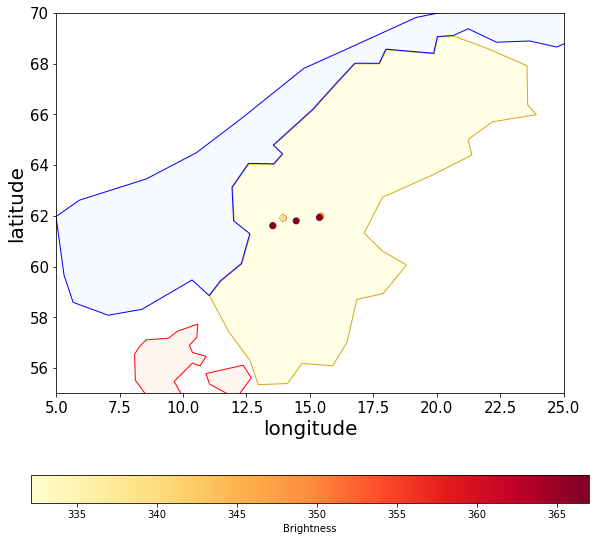

In [27]:
modis.plotfire_shp(biggest_firest,'Fires in Sweden, May thorugh August, big fires')

# Making geojson
Each of the fires will now be turend in to a footprint in geojson format. For inforamtion on this, see the report.

In [6]:
footprints = get_fires(shps[2],verbose=1)

------------------------------
(get_fires): Changing directory to C:\Users\krist\Documents\syntese\code\notebooks\Modis/geojson
------------------------------
1 (get_fires): file MODIS_2018-05-28_66.3463_21.8257.geojson already exists


NameError: name 'Point' is not defined

As we could see, I have made the footprints before. They are therefor NOT saved.

In [42]:
footprint2 = geojson_to_wkt(read_geojson('geojson/MODIS_2018-07-19_63.5833_17.8365.geojson'))
print('\nFootprint I made using my function\n'+footprint2)



Footprint I made using my function
POINT(17.8365 63.5833)
